# Stacking Ensemble Machine Learning (Stacked Generalization)
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score
import pickle

import plotly.express as px

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("../Datas/data.csv")

In [3]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

In [4]:
df_final_X = df.drop(["datetime","count"], axis=1)
df_final_y = np.log1p(df["count"])


In [5]:
df_final_X.describe()

,season,holiday,workingday,weather,temp,humidity,windspeed,month,day_number,year,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418335,20.23086,61.886460,12.799395,6.521495,9.992559,2011.501929,11.541613
std,1.116174,0.166599,0.466159,0.633537,7.79159,19.245033,8.164537,3.444373,5.476608,0.500019,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.000000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,47.000000,7.001500,4.000000,5.000000,2011.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,62.000000,12.998000,7.000000,10.000000,2012.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,77.000000,16.997900,10.000000,15.000000,2012.000000,18.000000
max,4.000000,1.000000,1.000000,3.000000,41.00000,100.000000,56.996900,12.000000,19.000000,2012.000000,23.000000


In [6]:
df_final_y.describe()

count    10886.000000
mean         4.591364
std          1.419454
min          0.693147
25%          3.761200
50%          4.983607
75%          5.652489
max          6.885510
Name: count, dtype: float64

In [7]:
one_hot_features = ["weather", "holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [8]:

# get a list of models to evaluate



In [9]:
rfr = make_pipeline(processor, RandomForestRegressor(random_state=1))
etr = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
lgbm = make_pipeline(processor, LGBMRegressor(random_state=1))
xgbr = make_pipeline(processor, XGBRegressor(random_state=1))

In [10]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
    models = dict()
    models['rfr'] = make_pipeline(processor, RandomForestRegressor(random_state=1))
    models['etr'] = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
    models['lgbm'] = make_pipeline(processor, LGBMRegressor(random_state=1))
    models['xgbr'] = make_pipeline(processor, XGBRegressor(random_state=1))
    
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train, X_test, y_test):
	
	model.fit(X_train, y_train)
	scores = model.score(X_test, y_test)

	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model,X_train, y_train, X_test, y_test)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>rfr 0.905 (0.000)
>etr 0.938 (0.000)
>lgbm 0.930 (0.000)
>xgbr 0.925 (0.000)


In [11]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingRegressor

# define the base models
level0 = list()

level0.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1)
# fit the model on all available data
model.fit(X_train, y_train)
# make a prediction for one example

y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [12]:
model.score(X_test,y_test)

0.9351436450058414

In [13]:
model.stack_method

'predict'

In [14]:
tmp = {'y_test': y_test, 'y_pred':y_pred}
result = pd.DataFrame(data=tmp , columns=['y_test','y_pred'])
result['diff'] = result['y_test'] - result['y_pred'] 

In [15]:
X_test

,season,holiday,workingday,weather,temp,humidity,windspeed,day,month,day_number,year,hour
9063,3,0,0,1,30.34,62,7.0015,Saturday,9,1,2012,0
9064,3,0,0,1,29.52,74,8.9981,Saturday,9,1,2012,1
9065,3,0,0,1,28.70,70,11.0014,Saturday,9,1,2012,2
9066,3,0,0,1,28.70,70,7.0015,Saturday,9,1,2012,3
9067,3,0,0,1,28.70,70,0.0000,Saturday,9,1,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,Wednesday,12,19,2012,19
10882,4,0,1,1,14.76,57,15.0013,Wednesday,12,19,2012,20
10883,4,0,1,1,13.94,61,15.0013,Wednesday,12,19,2012,21
10884,4,0,1,1,13.94,61,6.0032,Wednesday,12,19,2012,22


In [16]:


X_test_res = X_test
X_test_res["diff"] = result['y_test'] - result['y_pred'] 

px.scatter(X_test_res,y='diff',hover_data=["hour","humidity","temp","windspeed"])
#fig.update_traces(mode="markers")
# fig.show()

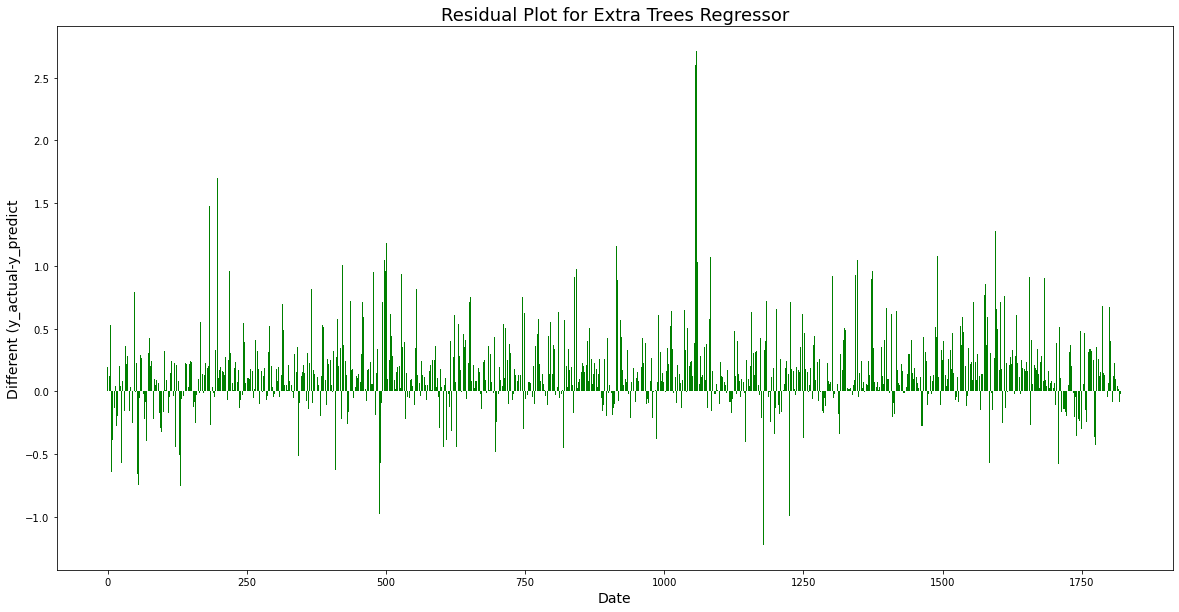

In [17]:
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
plt.title('Residual Plot for Extra Trees Regressor',fontsize=18)
x_axis = list(range(0, len(result)))
ax.bar(x_axis, result['diff'],color='green')
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Different (y_actual-y_predict',fontsize=14)

# ax2=ax.twinx()
# ax2.plot(df_group_month_sum['date_data'], df_group_month_sum['atemp'],color='blue',marker="o")
# ax2.set_ylabel('Feels like temperature')
plt.show()

## Plot y_pred vs y_actual for all

In [55]:
etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)
score_etr = etr.score(X_test, y_test)

rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
score_rfr = rfr.score(X_test, y_test)

xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
score_xgbr = xgbr.score(X_test, y_test)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
score_lgbm = lgbm.score(X_test, y_test)

model.fit(X_train, y_train)
y_pred_stack = model.predict(X_test)
score_stack = model.score(X_test, y_test)


In [19]:
y_test

9063     5.129899
9064     4.382027
9065     4.248495
9066     3.583519
9067     2.564949
           ...   
10881    5.820083
10882    5.488938
10883    5.129899
10884    4.867534
10885    4.488636
Name: count, Length: 1823, dtype: float64

In [20]:
plot_y_etr = pd.DataFrame(data=y_test, columns=['y_test'])
# plot_y_etr['y_test'] = y_test
plot_y_etr['y_test']=y_test
plot_y_etr['y_pred_etr']=y_pred_etr
plot_y_etr['y_pred_rfr']=y_pred_rfr
plot_y_etr['y_pred_xgbr']=y_pred_xgbr
plot_y_etr['y_pred_lgbm']=y_pred_lgbm
plot_y_etr['y_pred_stack']=y_pred_stack
plot_y_etr

,y_test,y_pred_etr,y_pred_rfr,y_pred_xgbr,y_pred_lgbm,y_pred_stack
9063,5.129899,5.078499,5.037487,4.931859,4.944779,4.937878
9064,4.382027,4.558402,4.613553,4.780262,4.721122,4.730161
9065,4.248495,4.209002,4.271408,4.478359,4.278377,4.268696
9066,3.583519,3.518858,3.533116,3.667225,3.492948,3.458277
9067,2.564949,2.239840,2.233777,2.659561,2.468180,2.459904
...,...,...,...,...,...,...
10881,5.820083,6.032792,5.710064,5.842140,5.781391,5.907364
10882,5.488938,5.612399,5.326273,5.653399,5.439787,5.571515
10883,5.129899,5.375965,5.034620,5.195533,5.041114,5.146614
10884,4.867534,5.124311,4.749576,4.977775,4.760090,4.872641


In [ ]:
label="RandomForest + ExtraTrees (R2 = %0.3f)" % score_1a)

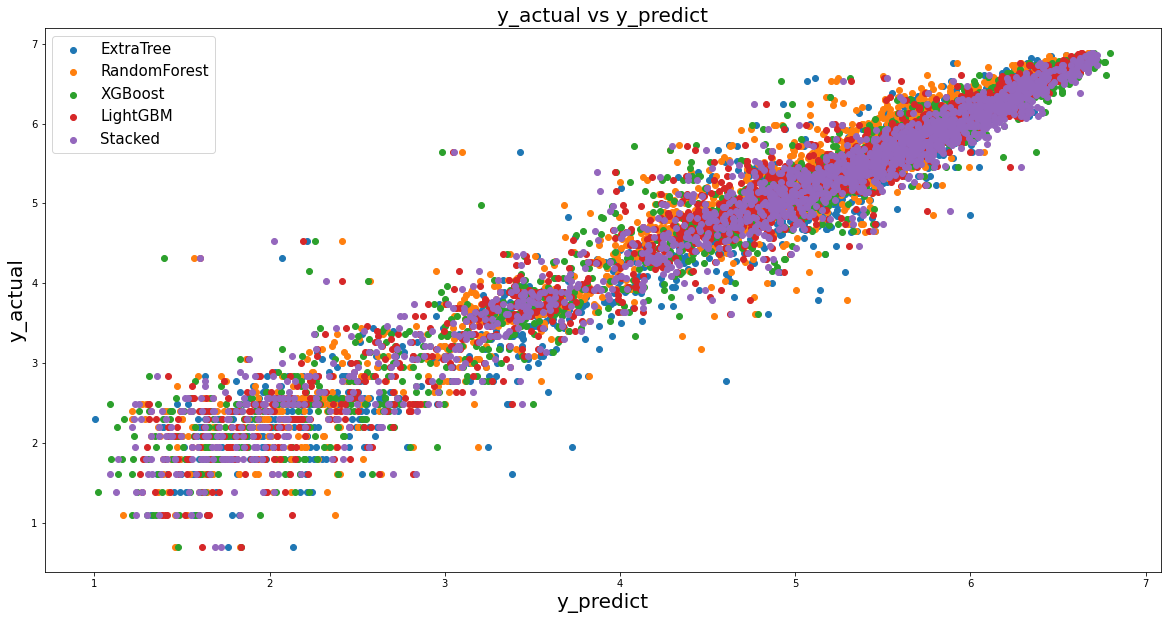

In [33]:
plt.scatter(plot_y_etr['y_pred_etr'], plot_y_etr['y_test'],label="ExtraTree (R2 = %0.3f)" % score_etr)
plt.scatter(plot_y_etr['y_pred_rfr'], plot_y_etr['y_test'],label="RandomForest (R2 = %0.3f)" % score_rfr)
plt.scatter(plot_y_etr['y_pred_xgbr'], plot_y_etr['y_test'],label="XGBoost (R2 = %0.3f)" % score_xgbr)
plt.scatter(plot_y_etr['y_pred_lgbm'], plot_y_etr['y_test'],label="LightGBM (R2 = %0.3f)" % score_lgbm)
plt.scatter(plot_y_etr['y_pred_stack'], plot_y_etr['y_test'],label="Stacked (R2 = %0.3f)" % score_stack)
plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

# Package using pickle library

In [22]:
model.fit(df_final_X, df_final_y)


StackingRegressor(estimators=[('rfr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['weather',
                                                                                  'holiday',
                                                                                  'workingday',
                                                                                  'season',
                                                                                  'month',
                                                                             

- pickle.dump(model_xgb, open(filename, 'wb'))
- loaded_model = pickle.load(open(filename, 'rb'))

In [23]:
# pickle.dump(model, open('model_stack.sav', 'wb'))

In [24]:
loaded_model = pickle.load(open('model_stack.sav', 'rb'))

In [25]:
loaded_model.score(X_test,y_test)

0.9788335974542952

## Smaller pickle files (doesnt work)

In [26]:
# etr.fit(X_train, y_train)
# pickle.dump(model, open('model_etr.sav', 'wb'))

# rfr.fit(X_train, y_train)
# pickle.dump(model, open('model_rfr.sav', 'wb'))

# xgbr.fit(X_train, y_train)
# pickle.dump(model, open('model_xgbr.sav', 'wb'))

# lgbm.fit(X_train, y_train)
# pickle.dump(model, open('model_lgbm.sav', 'wb'))

# model.fit(X_train, y_train)


In [27]:
# level0 = list()

# loaded_model1 = pickle.load(open('model_etr.sav', 'rb'))
# loaded_model2 = pickle.load(open('model_rfr.sav', 'rb'))
# loaded_model3 = pickle.load(open('model_xgbr.sav', 'rb'))
# loaded_model4 = pickle.load(open('model_lgbm.sav', 'rb'))

# level0.append(('rfr', loaded_model1))
# level0.append(('etr', loaded_model2))
# level0.append(('lgbm', loaded_model3))
# level0.append(('xgbr', loaded_model4))

# # define meta learner model
# level1 = LinearRegression()
# # define the stacking ensemble
# model = StackingRegressor(estimators=level0, final_estimator=level1)
# # fit the model on all available data
# model.fit(X_train, y_train)
# score = model.score(X_test,y_test)
# score

## Experiment with different stacking combination (pair)
* 1a) rfr + etr
* 1b) rfr + lgbm
* 1c) rfr + xgbr
* 2a) etr + lgbm
* 2b) etr + xgbr
* 3a) lgbm + xgbr


In [28]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingRegressor

# define the base models
level0_1a = list()
level0_1b = list()
level0_1c = list()
level0_2a = list()
level0_2b = list()
level0_3a = list()

level0_1a.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))

level0_1b.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1b.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_1c.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1c.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_2a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_2b.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2b.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_3a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_3a.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
model_1a = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a.fit(X_train, y_train)
model_1b.fit(X_train, y_train)
model_1c.fit(X_train, y_train)
model_2a.fit(X_train, y_train)
model_2b.fit(X_train, y_train)
model_3a.fit(X_train, y_train)

# Get score for each models
score_1a = model_1a.score(X_test, y_test)
score_1b = model_1b.score(X_test, y_test)
score_1c = model_1c.score(X_test, y_test)
score_2a = model_2a.score(X_test, y_test)
score_2b = model_2b.score(X_test, y_test)
score_3a = model_3a.score(X_test, y_test)

# y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [30]:
# print all scores
print('R2 score for 1a: %.3f' % (score_1a))
print('R2 score for 1b: %.3f' % (score_1b))
print('R2 score for 1c: %.3f' % (score_1c))
print('R2 score for 2a: %.3f' % (score_2a))
print('R2 score for 2b: %.3f' % (score_2b))
print('R2 score for 3a: %.3f' % (score_3a))

R2 score for 1a: 0.937
R2 score for 1b: 0.928
R2 score for 1c: 0.930
R2 score for 2a: 0.935
R2 score for 2b: 0.938
R2 score for 3a: 0.932


## Experiment with different stacking combination (3 in group)
* A) rfr + etr + lgbm
* B) rfr + etr + xgbr
* C) etr + lgbm + xgbr


In [31]:
# define the base models
level0_A = list()
level0_B = list()
level0_C = list()

level0_A.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_A.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_A.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_B.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_B.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_B.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_C.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_C.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_C.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))


# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
model_A = StackingRegressor(estimators=level0_A, final_estimator=level1)
model_B = StackingRegressor(estimators=level0_B, final_estimator=level1)
model_C = StackingRegressor(estimators=level0_C, final_estimator=level1)


# fit the model on all available data
model_A.fit(X_train, y_train)
model_B.fit(X_train, y_train)
model_C.fit(X_train, y_train)


# Get score for each models
score_A = model_A.score(X_test, y_test)
score_B = model_B.score(X_test, y_test)
score_C = model_C.score(X_test, y_test)


# y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [32]:
# print all scores
print('R2 score for A: %.3f' % (score_A))
print('R2 score for B: %.3f' % (score_B))
print('R2 score for C: %.3f' % (score_C))


R2 score for A: 0.935
R2 score for B: 0.938
R2 score for C: 0.935


## Y_actual vs Y_predict

In [35]:
y_pred_1a = model_1a.predict(X_test)
y_pred_1b = model_1b.predict(X_test)
y_pred_1c = model_1c.predict(X_test)
y_pred_2a = model_2a.predict(X_test)
y_pred_2b = model_2b.predict(X_test)
y_pred_3a = model_3a.predict(X_test)

In [38]:
plot_y_stack2 = pd.DataFrame(data=y_test, columns=['y_test'])

plot_y_stack2['y_test']=y_test
plot_y_stack2['y_pred_1a']=y_pred_1a
plot_y_stack2['y_pred_1b']=y_pred_1b
plot_y_stack2['y_pred_1c']=y_pred_1c
plot_y_stack2['y_pred_2a']=y_pred_2a
plot_y_stack2['y_pred_2b']=y_pred_2b
plot_y_stack2['y_pred_3a']=y_pred_3a
plot_y_stack2

,y_test,y_pred_1a,y_pred_1b,y_pred_1c,y_pred_2a,y_pred_2b,y_pred_3a
9063,5.129899,5.083425,4.927671,4.970166,4.977179,4.991769,4.961382
9064,4.382027,4.603176,4.752240,4.767729,4.716549,4.718087,4.740908
9065,4.248495,4.257596,4.271222,4.459780,4.273827,4.398885,4.304272
9066,3.583519,3.549995,3.453229,3.666710,3.480871,3.623068,3.500420
9067,2.564949,2.266199,2.476401,2.609029,2.405533,2.520542,2.456993
...,...,...,...,...,...,...,...
10881,5.820083,5.922475,5.829594,5.830605,5.845401,5.921571,5.822532
10882,5.488938,5.517832,5.490695,5.605872,5.487581,5.655565,5.490334
10883,5.129899,5.259921,5.053137,5.181922,5.097346,5.268021,5.077411
10884,4.867534,4.995565,4.766081,4.952548,4.813120,5.037905,4.797490


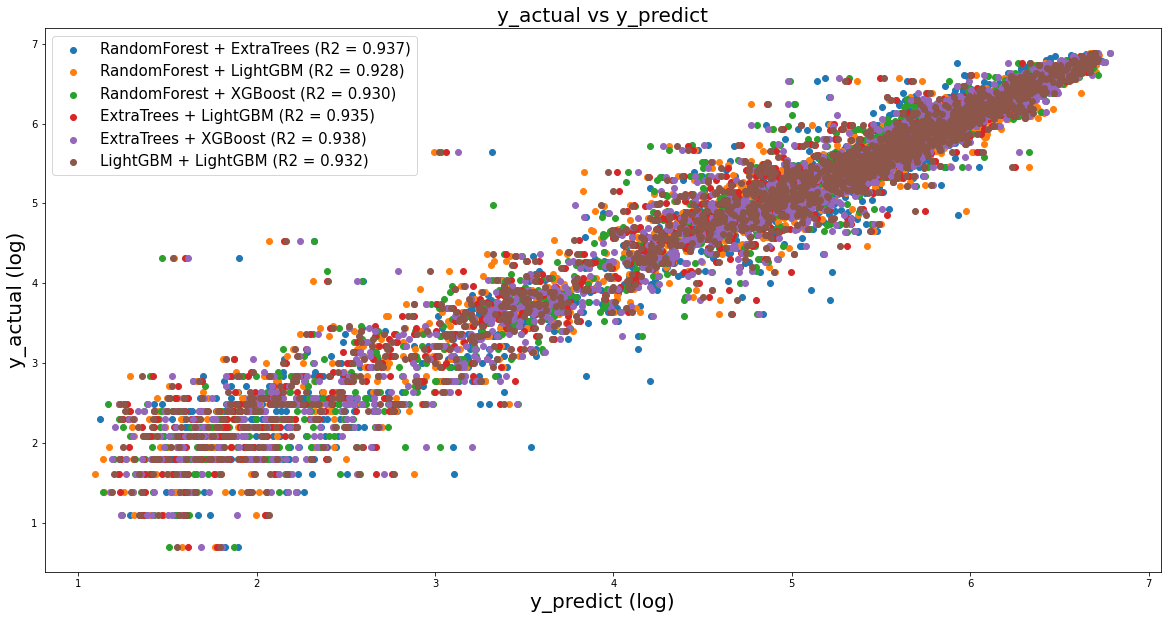

In [42]:
plt.scatter(plot_y_stack2['y_pred_1a'], plot_y_stack2['y_test'],label="RandomForest + ExtraTrees (R2 = %0.3f)" % score_1a)
plt.scatter(plot_y_stack2['y_pred_1b'], plot_y_stack2['y_test'],label="RandomForest + LightGBM (R2 = %0.3f)" % score_1b)
plt.scatter(plot_y_stack2['y_pred_1c'], plot_y_stack2['y_test'],label="RandomForest + XGBoost (R2 = %0.3f)" % score_1c)
plt.scatter(plot_y_stack2['y_pred_2a'], plot_y_stack2['y_test'],label="ExtraTrees + LightGBM (R2 = %0.3f)" % score_2a)
plt.scatter(plot_y_stack2['y_pred_2b'], plot_y_stack2['y_test'],label="ExtraTrees + XGBoost (R2 = %0.3f)" % score_2b)
plt.scatter(plot_y_stack2['y_pred_3a'], plot_y_stack2['y_test'],label="LightGBM + LightGBM (R2 = %0.3f)" % score_3a)
plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

In [43]:
y_pred_A = model_A.predict(X_test)
y_pred_B = model_B.predict(X_test)
y_pred_C = model_C.predict(X_test)


plot_y_stack3 = pd.DataFrame(data=y_test, columns=['y_test'])

plot_y_stack3['y_test']=y_test
plot_y_stack3['y_pred_A']=y_pred_A
plot_y_stack3['y_pred_B']=y_pred_B
plot_y_stack3['y_pred_C']=y_pred_C

plot_y_stack3

,y_test,y_pred_A,y_pred_B,y_pred_C
9063,5.129899,4.943772,4.991905,4.974251
9064,4.382027,4.718734,4.718063,4.723255
9065,4.248495,4.244165,4.398837,4.288791
9066,3.583519,3.438542,3.623060,3.493213
9067,2.564949,2.428335,2.520266,2.423784
...,...,...,...,...
10881,5.820083,5.906500,5.921205,5.844905
10882,5.488938,5.550782,5.655056,5.498774
10883,5.129899,5.137042,5.267625,5.102341
10884,4.867534,4.856247,5.037419,4.822083


* A) rfr + etr + lgbm
* B) rfr + etr + xgbr
* C) etr + lgbm + xgbr

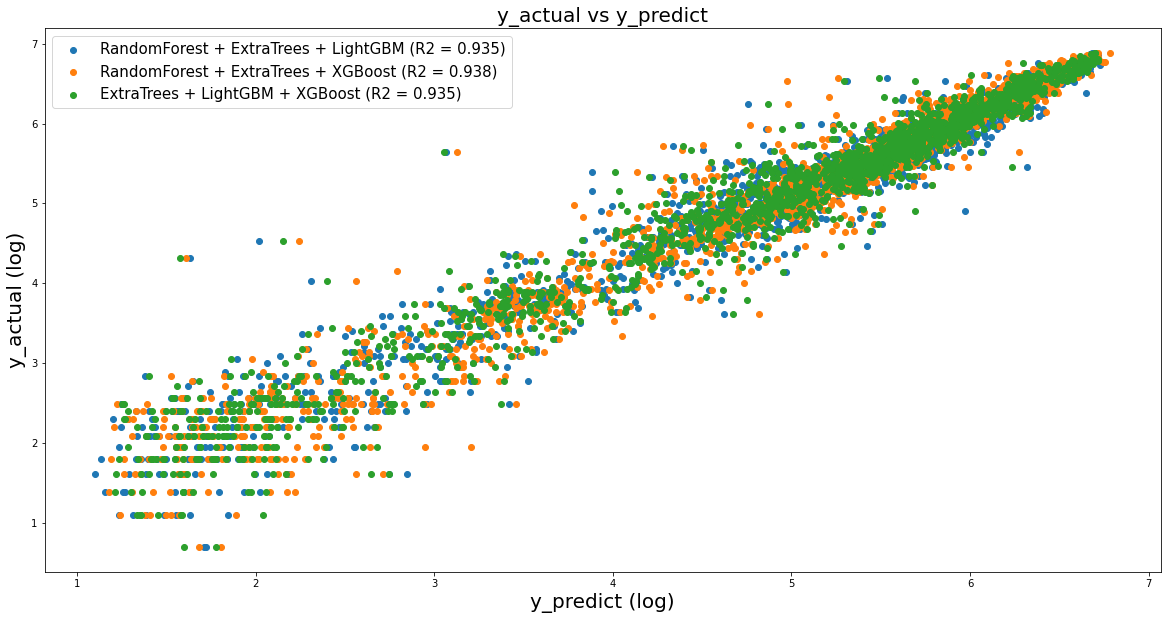

In [44]:
plt.scatter(plot_y_stack3['y_pred_A'], plot_y_stack3['y_test'],label="RandomForest + ExtraTrees + LightGBM (R2 = %0.3f)" % score_A)
plt.scatter(plot_y_stack3['y_pred_B'], plot_y_stack3['y_test'],label="RandomForest + ExtraTrees + XGBoost (R2 = %0.3f)" % score_B)
plt.scatter(plot_y_stack3['y_pred_C'], plot_y_stack3['y_test'],label="ExtraTrees + LightGBM + XGBoost (R2 = %0.3f)" % score_C)

plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

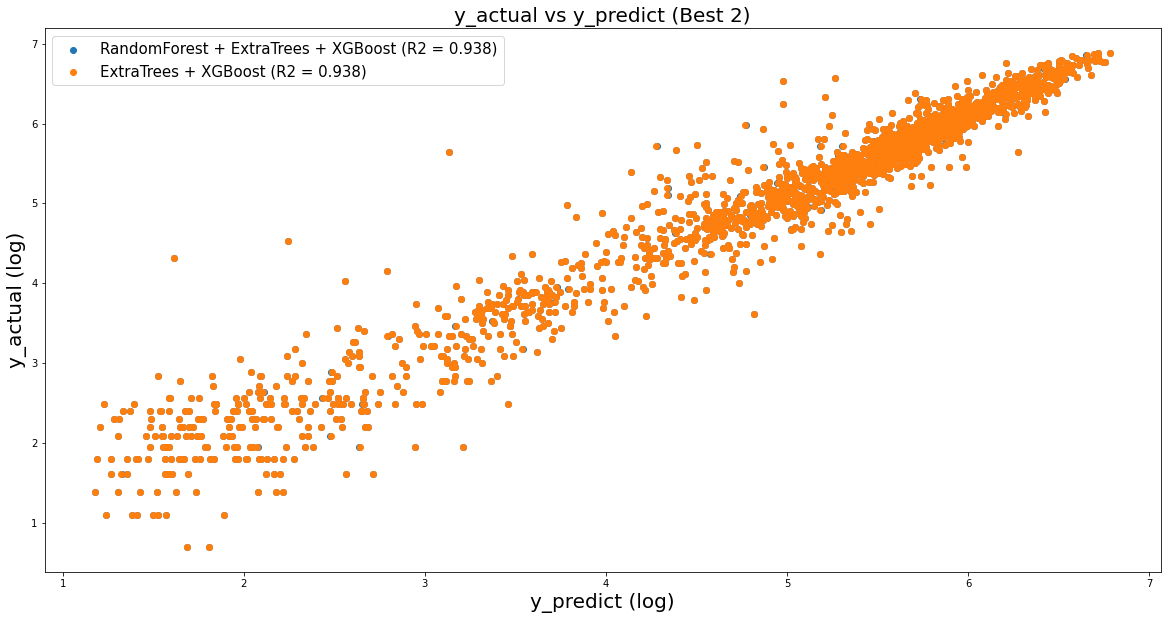

In [45]:
plt.scatter(plot_y_stack3['y_pred_B'], plot_y_stack3['y_test'],label="RandomForest + ExtraTrees + XGBoost (R2 = %0.3f)" % score_B)
plt.scatter(plot_y_stack2['y_pred_2b'], plot_y_stack2['y_test'],label="ExtraTrees + XGBoost (R2 = %0.3f)" % score_2b)

plt.title('y_actual vs y_predict (Best 2)', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

# Trying different level 1 stacking model gridsearch

https://www.analyticsvidhya.com/blog/2020/12/improve-predictive-model-score-stacking-regressor/

### RidgeCV

In [46]:
# define the base models
level0_1a = list()
level0_1b = list()
level0_1c = list()
level0_2a = list()
level0_2b = list()
level0_3a = list()

level0_1a.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))

level0_1b.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1b.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_1c.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1c.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_2a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_2b.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2b.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_3a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_3a.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

# define meta learner model Default = RidgeCV
# level1 = LinearRegression()

# define the stacking ensemble
model_1a_Ridge = StackingRegressor(estimators=level0_1a)
model_1b_Ridge = StackingRegressor(estimators=level0_1b)
model_1c_Ridge = StackingRegressor(estimators=level0_1c)
model_2a_Ridge = StackingRegressor(estimators=level0_2a)
model_2b_Ridge = StackingRegressor(estimators=level0_2b)
model_3a_Ridge = StackingRegressor(estimators=level0_3a)

# fit the model on all available data
model_1a_Ridge.fit(X_train, y_train)
model_1b_Ridge.fit(X_train, y_train)
model_1c_Ridge.fit(X_train, y_train)
model_2a_Ridge.fit(X_train, y_train)
model_2b_Ridge.fit(X_train, y_train)
model_3a_Ridge.fit(X_train, y_train)

# Get score for each models
score_1a_Ridge = model_1a_Ridge.score(X_test, y_test)
score_1b_Ridge = model_1b_Ridge.score(X_test, y_test)
score_1c_Ridge = model_1c_Ridge.score(X_test, y_test)
score_2a_Ridge = model_2a_Ridge.score(X_test, y_test)
score_2b_Ridge = model_2b_Ridge.score(X_test, y_test)
score_3a_Ridge = model_3a_Ridge.score(X_test, y_test)

In [47]:
# print all scores
print('R2 score for 1a (RidgeCV): %.3f' % (score_1a_Ridge))
print('R2 score for 1b (RidgeCV): %.3f' % (score_1b_Ridge))
print('R2 score for 1c (RidgeCV): %.3f' % (score_1c_Ridge))
print('R2 score for 2a (RidgeCV): %.3f' % (score_2a_Ridge))
print('R2 score for 2b (RidgeCV): %.3f' % (score_2b_Ridge))
print('R2 score for 3a (RidgeCV): %.3f' % (score_3a_Ridge))

R2 score for 1a (RidgeCV): 0.937
R2 score for 1b (RidgeCV): 0.928
R2 score for 1c (RidgeCV): 0.930
R2 score for 2a (RidgeCV): 0.935
R2 score for 2b (RidgeCV): 0.938
R2 score for 3a (RidgeCV): 0.932


### Linear SVR

In [48]:
from sklearn.svm import LinearSVR

# define meta learner model
level1 = LinearSVR()

# define the stacking ensemble
model_1a_LinearSVR = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b_LinearSVR = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c_LinearSVR = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a_LinearSVR = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b_LinearSVR = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a_LinearSVR = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a_LinearSVR.fit(X_train, y_train)
model_1b_LinearSVR.fit(X_train, y_train)
model_1c_LinearSVR.fit(X_train, y_train)
model_2a_LinearSVR.fit(X_train, y_train)
model_2b_LinearSVR.fit(X_train, y_train)
model_3a_LinearSVR.fit(X_train, y_train)

# Get score for each models
score_1a_LinearSVR = model_1a_LinearSVR.score(X_test, y_test)
score_1b_LinearSVR = model_1b_LinearSVR.score(X_test, y_test)
score_1c_LinearSVR = model_1c_LinearSVR.score(X_test, y_test)
score_2a_LinearSVR = model_2a_LinearSVR.score(X_test, y_test)
score_2b_LinearSVR = model_2b_LinearSVR.score(X_test, y_test)
score_3a_LinearSVR = model_3a_LinearSVR.score(X_test, y_test)

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed

In [49]:
# print all scores
print('R2 score for 1a (LinearSVR): %.3f' % (score_1a_LinearSVR))
print('R2 score for 1b (LinearSVR): %.3f' % (score_1b_LinearSVR))
print('R2 score for 1c (LinearSVR): %.3f' % (score_1c_LinearSVR))
print('R2 score for 2a (LinearSVR): %.3f' % (score_2a_LinearSVR))
print('R2 score for 2b (LinearSVR): %.3f' % (score_2b_LinearSVR))
print('R2 score for 3a (LinearSVR): %.3f' % (score_3a_LinearSVR))

R2 score for 1a (LinearSVR): 0.943
R2 score for 1b (LinearSVR): 0.939
R2 score for 1c (LinearSVR): 0.942
R2 score for 2a (LinearSVR): 0.948
R2 score for 2b (LinearSVR): 0.948
R2 score for 3a (LinearSVR): 0.937


### LassoCV

In [51]:
from sklearn.linear_model import LassoCV

# define meta learner model
level1 = LassoCV()

# define the stacking ensemble
model_1a_LassoCV = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b_LassoCV = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c_LassoCV = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a_LassoCV = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b_LassoCV = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a_LassoCV = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a_LassoCV.fit(X_train, y_train)
model_1b_LassoCV.fit(X_train, y_train)
model_1c_LassoCV.fit(X_train, y_train)
model_2a_LassoCV.fit(X_train, y_train)
model_2b_LassoCV.fit(X_train, y_train)
model_3a_LassoCV.fit(X_train, y_train)

# Get score for each models
score_1a_LassoCV = model_1a_LassoCV.score(X_test, y_test)
score_1b_LassoCV = model_1b_LassoCV.score(X_test, y_test)
score_1c_LassoCV = model_1c_LassoCV.score(X_test, y_test)
score_2a_LassoCV = model_2a_LassoCV.score(X_test, y_test)
score_2b_LassoCV = model_2b_LassoCV.score(X_test, y_test)
score_3a_LassoCV = model_3a_LassoCV.score(X_test, y_test)

In [52]:
# print all scores
print('R2 score for 1a (LassoCV): %.3f' % (score_1a_LassoCV))
print('R2 score for 1b (LassoCV): %.3f' % (score_1b_LassoCV))
print('R2 score for 1c (LassoCV): %.3f' % (score_1c_LassoCV))
print('R2 score for 2a (LassoCV): %.3f' % (score_2a_LassoCV))
print('R2 score for 2b (LassoCV): %.3f' % (score_2b_LassoCV))
print('R2 score for 3a (LassoCV): %.3f' % (score_3a_LassoCV))

R2 score for 1a (LassoCV): 0.936
R2 score for 1b (LassoCV): 0.932
R2 score for 1c (LassoCV): 0.930
R2 score for 2a (LassoCV): 0.935
R2 score for 2b (LassoCV): 0.938
R2 score for 3a (LassoCV): 0.932


### ElasticNet

In [53]:
from sklearn.linear_model import ElasticNetCV

# define meta learner model
level1 = ElasticNetCV()

# define the stacking ensemble
model_1a_ElasticNetCV = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b_ElasticNetCV = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c_ElasticNetCV = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a_ElasticNetCV = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b_ElasticNetCV = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a_ElasticNetCV = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a_ElasticNetCV.fit(X_train, y_train)
model_1b_ElasticNetCV.fit(X_train, y_train)
model_1c_ElasticNetCV.fit(X_train, y_train)
model_2a_ElasticNetCV.fit(X_train, y_train)
model_2b_ElasticNetCV.fit(X_train, y_train)
model_3a_ElasticNetCV.fit(X_train, y_train)

# Get score for each models
score_1a_ElasticNetCV = model_1a_ElasticNetCV.score(X_test, y_test)
score_1b_ElasticNetCV = model_1b_ElasticNetCV.score(X_test, y_test)
score_1c_ElasticNetCV = model_1c_ElasticNetCV.score(X_test, y_test)
score_2a_ElasticNetCV = model_2a_ElasticNetCV.score(X_test, y_test)
score_2b_ElasticNetCV = model_2b_ElasticNetCV.score(X_test, y_test)
score_3a_ElasticNetCV = model_3a_ElasticNetCV.score(X_test, y_test)

In [54]:
# print all scores
print('R2 score for 1a (ElasticNetCV): %.3f' % (score_1a_ElasticNetCV))
print('R2 score for 1b (ElasticNetCV): %.3f' % (score_1b_ElasticNetCV))
print('R2 score for 1c (ElasticNetCV): %.3f' % (score_1c_ElasticNetCV))
print('R2 score for 2a (ElasticNetCV): %.3f' % (score_2a_ElasticNetCV))
print('R2 score for 2b (ElasticNetCV): %.3f' % (score_2b_ElasticNetCV))
print('R2 score for 3a (ElasticNetCV): %.3f' % (score_3a_ElasticNetCV))

R2 score for 1a (ElasticNetCV): 0.934
R2 score for 1b (ElasticNetCV): 0.931
R2 score for 1c (ElasticNetCV): 0.930
R2 score for 2a (ElasticNetCV): 0.935
R2 score for 2b (ElasticNetCV): 0.939
R2 score for 3a (ElasticNetCV): 0.933
